# Higgs Classification

-- mKnipfer

This model is not really working well, but I implemented some methods that might be helpful.
Also it's kind of a mess and should be abstracted more.

Also I looked so much at the test data by optimizing for the roc curve that I think I leaked most of the information from the test data into the training already.

I don't know if the random forrest model is really good or leaking some info from test. I just copied the code from the source and
used it on the same features as for the KNN and NN (separate train/test split though).


Sources:
- https://machinelearningmastery.com/how-to-stop-training-deep-neural-networks-at-the-right-time-using-early-stopping/
- https://www.kaggle.com/georsara1/95-auc-score-in-train-sample-with-neural-nets
- Higgs_Classification_Guillermo.ipynb
- https://arxiv.org/pdf/1902.08570.pdf


How to run:
- just like the example notebooks in lhcmlhackathon/notebooks
- need data in data/Higgs_data.root
- probably need `pip install tqdm root_pandas keras_tqdm`

Features:
- Neural Network, Choose which Features to use
- Min/Max Scaler
- New data features generated
- Use KNN_Score if you want (use_KNN = True). Deafault is off, since it only makes it worse ...

ToDo:
- Clean up variables/models
- try implementing random forest output as NN input

In [1]:
knn_neighbors = 20
batch_size = 40
epochs = 50
use_KNN = False
early_stopping = 10 # stop training after 15 epochs no good change

In [2]:
import os
import numpy as np
import pandas as pd
from root_pandas import read_root
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import precision_recall_curve, confusion_matrix, accuracy_score, roc_curve, auc
from sklearn.metrics import f1_score, average_precision_score

from keras.models import Sequential
from keras.optimizers import Adam, SGD
from keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Reshape, BatchNormalization, Activation
from keras.regularizers import l1, l2
from keras.utils import to_categorical
from keras import optimizers
from keras.callbacks import EarlyStopping

from keras_tqdm import TQDMNotebookCallback # Model learning progress bar

os.environ["KERAS_BACKEND"] = "tensorflow"
np.random.seed(42)
%matplotlib inline

Welcome to JupyROOT 6.18/02


Using TensorFlow backend.
/home/mknipfer/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/mknipfer/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/mknipfer/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/mknipfer/.local/lib/python3.7/site-packages/tensorflo

In [3]:
data_path = "data/Higgs_data.root"
df_signalTree = read_root(data_path, "sig_tree")
df_backgroundTree = read_root(data_path, "bkg_tree")

## Data Preparation
try new features

In [4]:
# add flag data
# 1: signal
# 2: no signal
df_signalTree['y'] = 1
df_backgroundTree['y'] = 0
df_all = pd.concat([df_signalTree, df_backgroundTree])

In [5]:
def square(a,b):
    return a*a + b*b

# y / x
def angle(a,b):
    return np.arctan2(b,a)

df_all['A'] = square(df_all['lepton_pT'], df_all['lepton_eta'])
df_all['Aangle'] = angle(df_all['lepton_pT'], df_all['lepton_eta'])
df_all['B'] = square(df_all['lepton_pT'], df_all['missing_energy_magnitude'])
df_all['Bangle'] = angle(df_all['lepton_pT'], df_all['missing_energy_magnitude'])
df_all['C'] = square(df_all['lepton_pT'], df_all['jet1_pt'])
df_all['Cangle'] = angle(df_all['lepton_pT'], df_all['jet1_pt'])
df_all['D'] = square(df_all['lepton_pT'], df_all['jet4_pt'])
df_all['Dangle'] = angle(df_all['lepton_pT'], df_all['jet4_pt'])
df_all['E'] = square(df_all['missing_energy_magnitude'], df_all['jet1_pt'])
df_all['Eangle'] = angle(df_all['missing_energy_magnitude'], df_all['jet1_pt'])
df_all['F'] = square(df_all['missing_energy_magnitude'], df_all['jet2_pt'])
df_all['Fangle'] = angle(df_all['missing_energy_magnitude'], df_all['jet2_pt'])

df_all['Z'] = square(df_all['m_jlv'], df_all['m_bb'])
df_all['Zangle'] = angle(df_all['m_jlv'], df_all['m_bb'])

# turns out those new variables don't really help ...

In [6]:
raw_cols = ['lepton_pT', 'lepton_eta', 'lepton_phi', 'missing_energy_magnitude',
       'missing_energy_phi', 'jet1_pt', 'jet1_eta', 'jet1_phi', 'jet1_btag',
       'jet2_pt', 'jet2_eta', 'jet2_phi', 'jet2_btag', 'jet3_pt', 'jet3_eta',
       'jet3_phi', 'jet3_btag', 'jet4_pt', 'jet4_eta', 'jet4_phi', 'jet4_btag']
man_cols = ['m_jj', 'm_jjj', 'm_lv', 'm_jlv', 'm_bb', 'm_wbb', 'm_wwbb']
new_cols = ['A', 'Aangle', 'B', 'Bangle', 'C', 'Cangle', 'D', 'Dangle', 
            'E', 'Eangle', 'F', 'Fangle', 'Z', 'Zangle']

use_cols = ['m_jj', 'm_jjj', 'm_lv', 'm_jlv', 'm_bb', 'm_wbb', 'm_wwbb'] + ['lepton_pT', 'missing_energy_magnitude', 'jet1_pt', 'jet2_pt'] + [
    'Z', 'Eangle'] 
# can use more variables, but they were worse for me

input_dim = len(use_cols)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(df_all[use_cols], df_all['y'], test_size = 0.30, random_state= 42)
y_train = to_categorical(y_train) # for categorical_crossentropy
y_test = to_categorical(y_test)

In [8]:
# Scale Data for faster convergence (hopefully)
#scaler = StandardScaler()
scaler = MinMaxScaler()

scaler.fit(X_train) # train scaler only on train data, don't leak!
X_train[X_train.columns] = scaler.transform(X_train)
X_test[X_test.columns] = scaler.transform(X_test)

##  K-Nearest-Neigbors KNN
if `use_KNN`: Use the output of KNN as additional input for NN

f1=0.623 auc=0.697 ap=0.683


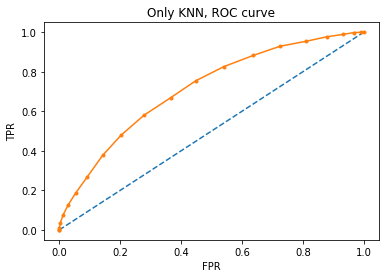

In [9]:
knn = KNeighborsClassifier(n_neighbors = knn_neighbors)
knn.fit(X_train, y_train[:,0])

probs = knn.predict_proba(X_test)
# [cat1, cat2] --> only need to keep one

probs = probs[:, 1]

yhat = knn.predict(X_test)

precision, recall, thresholds = precision_recall_curve(y_test[:,0], probs)
fpr, tpr, thresholds = roc_curve(y_test[:,0], probs)

f1 = f1_score(y_test[:,0], yhat)

auc_value = auc(recall, precision)

ap = average_precision_score(y_test[:,0], probs)
print('f1=%.3f auc=%.3f ap=%.3f' % (f1, auc_value, ap))


#plt.plot([0, 1], [0.1, 0.1], linestyle='--') # random / no skill
#plt.plot(recall, precision, marker='.')
#plt.show()

plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr, marker='.')
plt.title('Only KNN, ROC curve')
plt.ylabel('TPR')
plt.xlabel('FPR')
# show the plot
plt.show()

In [10]:
# add knn score as extra feature
if use_KNN:
    X_train['KNN_score'] = knn.predict_proba(X_train)[:,0]
    X_test['KNN_score'] = knn.predict_proba(X_test)[:,0]
    
input_dim = X_train.shape[1]

# Neural Network

In [11]:
from keras.layers import LeakyReLU
# leaky relu. Does not improve this model ...
lrelu = lambda x: LeakyReLU(alpha=0.1)(x) # use activation = lrelu


model = Sequential()
model.add(Dense(256, kernel_initializer='glorot_normal', activation='linear', input_dim=input_dim))
model.add(BatchNormalization())

model.add(Dense(256, kernel_initializer='glorot_normal', activation='relu'))
model.add(Dense(256, kernel_initializer='glorot_normal', activation='linear'))
model.add(BatchNormalization())

model.add(Dense(256, kernel_initializer='glorot_normal', activation='relu'))
model.add(Dense(256, kernel_initializer='glorot_normal', activation='linear'))
model.add(BatchNormalization())

model.add(Dense(256, kernel_initializer='glorot_normal', activation='relu'))
model.add(Dense(256, kernel_initializer='glorot_normal', activation='linear'))
model.add(BatchNormalization())

model.add(Dense(256, kernel_initializer='glorot_normal', activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(2, kernel_initializer='glorot_uniform', activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['categorical_accuracy',])
model.save('model_dense.h5')
#model.summary()

2019-10-10 00:24:17.003971: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2019-10-10 00:24:17.023504: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2695265000 Hz
2019-10-10 00:24:17.023926: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55bb1fbb8890 executing computations on platform Host. Devices:
2019-10-10 00:24:17.023951: I tensorflow/compiler/xla/service/service.cc:175]   StreamExecutor device (0): <undefined>, <undefined>
2019-10-10 00:24:17.075240: W tensorflow/compiler/jit/mark_for_compilation_pass.cc:1412] (One-time warning): Not using XLA:CPU for cluster because envvar TF_XLA_FLAGS=--tf_xla_cpu_global_jit was not set.  If you want XLA:CPU, either set that envvar, or use experimental_jit_scope to enable XLA:CPU.  To confirm that XLA is active, pass --vmodule=xla_compilation_cache=1 (as a proper command-line flag, not via TF_XLA_FLAGS) 

In [12]:
# FIT MODEL
earlyStopping = EarlyStopping(monitor='val_loss', mode='min', verbose = 1, patience = early_stopping)
history = model.fit(X_train, y_train, validation_split = 0.2, epochs = epochs, 
                    batch_size = batch_size, verbose = 0, 
                    callbacks = [TQDMNotebookCallback(leave_inner = False, leave_outer = True), 
                                 earlyStopping])


Epoch 00024: early stopping


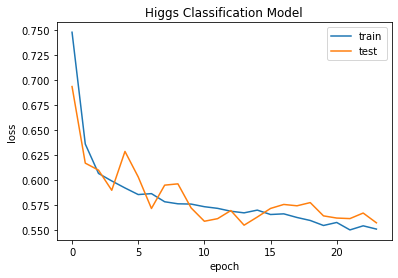

In [13]:
# Loss Plot
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Higgs Classification Model')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [14]:
# Predictions
probs_test = model.predict(X_test)[:,0]
predictions_test = np.where(probs_test > 0.5, 1, 0) 
# Accuracy
accuracy = accuracy_score(y_test[:,0], predictions_test)
print('Overall accuracy of Neural Network model:', accuracy)

false_positive_rate, recall, thresholds = roc_curve(y_test[:,0], probs_test)
roc_auc = auc(false_positive_rate, recall)

Overall accuracy of Neural Network model: 0.712


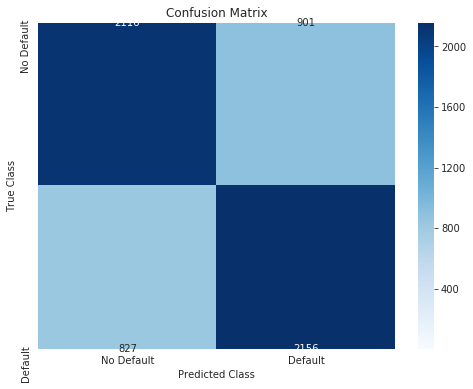

In [15]:
# Confusion Matrix
import seaborn as sns
sns.set_style("whitegrid")
cm = confusion_matrix(y_test[:,0], predictions_test)
labels = ['No Default', 'Default']
plt.figure(figsize=(8,6))
sns.heatmap(cm,xticklabels=labels, yticklabels=labels, annot=True, fmt='d', cmap="Blues", vmin = 0.2);
plt.title('Confusion Matrix')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.show()

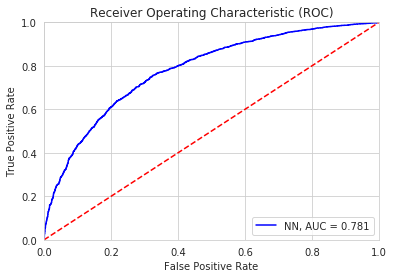

In [16]:
# Area Under ROC Curve


fig = plt.figure()
plt.title('Receiver Operating Characteristic (ROC)')
plt.plot(false_positive_rate, recall, 'b', label = 'AUC = %0.3f' %roc_auc)
plt.plot([0,1], [0,1], 'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(['NN, AUC = %0.3f' %roc_auc], loc='lower right')
plt.show()
fig.savefig('figures/NN-ROC')

## Random Forest
https://towardsdatascience.com/an-implementation-and-explanation-of-the-random-forest-in-python-77bf308a9b76

for all columns in `use_cols`


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    3.7s finished


Average number of nodes 4406
Average maximum depth 28


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      |

{'recall': 0.6856666666666666, 'precision': 0.7312477781727693, 'roc': 0.7911048333333334}
Recall Baseline: 1.0 Test: 0.69 Train: 1.0
Precision Baseline: 0.5 Test: 0.73 Train: 1.0
Roc Baseline: 0.5 Test: 0.79 Train: 1.0


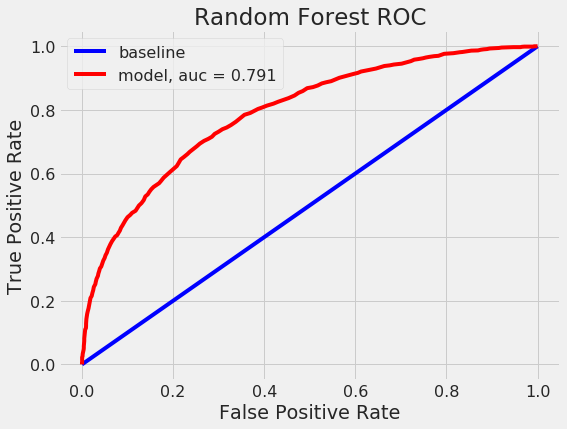

In [17]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

RSEED = 50
df = df_all[use_cols + ['y']]

# Extract the labels
labels = np.array(df.pop('y'))

# 30% examples in test data
train, test, train_labels, test_labels = train_test_split(df,
                                         labels, 
                                         stratify = labels,
                                         test_size = 0.3, 
                                         random_state = RSEED)

# Imputation of missing values
# train = train.fillna(train.mean())
# test = test.fillna(test.mean())

# Features for feature importances
features = list(train.columns)

# Create the model with 100 trees
model = RandomForestClassifier(n_estimators=200,
                               random_state=RSEED, 
                               max_features = 'sqrt',
                               n_jobs=-1, verbose = 1)

# Fit on training data
model.fit(train, train_labels)


n_nodes = []
max_depths = []

# Stats about the trees in random forest
for ind_tree in model.estimators_:
    n_nodes.append(ind_tree.tree_.node_count)
    max_depths.append(ind_tree.tree_.max_depth)
    
print(f'Average number of nodes {int(np.mean(n_nodes))}')
print(f'Average maximum depth {int(np.mean(max_depths))}')

# Training predictions (to demonstrate overfitting)
train_rf_predictions = model.predict(train)
train_rf_probs = model.predict_proba(train)[:, 1]

# Testing predictions (to determine performance)
rf_predictions = model.predict(test)
rf_probs = model.predict_proba(test)[:, 1]

from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Plot formatting
plt.style.use('fivethirtyeight')
plt.rcParams['font.size'] = 18

def evaluate_model(predictions, probs, train_predictions, train_probs):
    """Compare machine learning model to baseline performance.
    Computes statistics and shows ROC curve."""
    
    baseline = {}
    
    baseline['recall'] = recall_score(test_labels, 
                                     [1 for _ in range(len(test_labels))])
    baseline['precision'] = precision_score(test_labels, 
                                      [1 for _ in range(len(test_labels))])
    baseline['roc'] = 0.5
    
    results = {}
    
    results['recall'] = recall_score(test_labels, predictions)
    results['precision'] = precision_score(test_labels, predictions)
    results['roc'] = roc_auc_score(test_labels, probs)
    print(results)
    
    train_results = {}
    train_results['recall'] = recall_score(train_labels, train_predictions)
    train_results['precision'] = precision_score(train_labels, train_predictions)
    train_results['roc'] = roc_auc_score(train_labels, train_probs)
    
    for metric in ['recall', 'precision', 'roc']:
        print(f'{metric.capitalize()} Baseline: {round(baseline[metric], 2)} Test: {round(results[metric], 2)} Train: {round(train_results[metric], 2)}')
    
    # Calculate false positive rates and true positive rates
    base_fpr, base_tpr, _ = roc_curve(test_labels, [1 for _ in range(len(test_labels))])
    model_fpr, model_tpr, _ = roc_curve(test_labels, probs)

    fig = plt.figure(figsize = (8, 6))
    plt.rcParams['font.size'] = 16
    
    # Plot both curves
    plt.plot(base_fpr, base_tpr, 'b', label = 'baseline')
    plt.plot(model_fpr, model_tpr, 'r', label = 'model, auc = %0.3f' %results['roc'])
    plt.legend();
    plt.xlabel('False Positive Rate'); 
    plt.ylabel('True Positive Rate'); plt.title('Random Forest ROC');
    plt.show();
    fig.savefig('figures/random_forest.png')
    return model_fpr, model_tpr, results['roc']

randomForest_FPR, randomForest_TPR, randomForest_auc = evaluate_model(rf_predictions, rf_probs, train_rf_predictions, train_rf_probs)

#plt.savefig('cm.png')

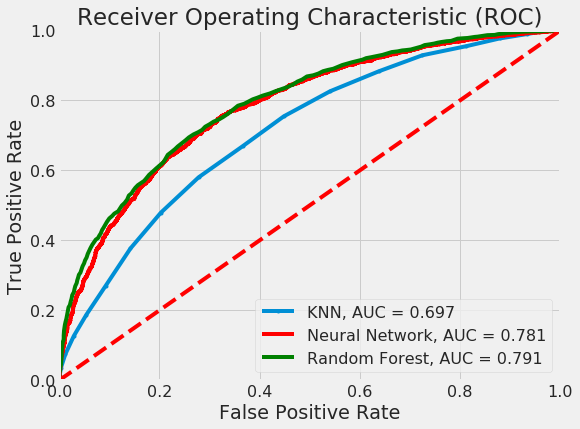

In [18]:
# Area Under ROC Curve
false_positive_rate, recall, thresholds = roc_curve(y_test[:,0], probs_test)
roc_auc = auc(false_positive_rate, recall)
fig = plt.figure(figsize = (8, 6))
plt.title('Receiver Operating Characteristic (ROC)')
plt.plot(fpr, tpr, marker='.') # KNN
plt.plot(false_positive_rate, recall, 'r', label = 'AUC = %0.3f' %roc_auc) # NN
plt.plot(randomForest_FPR, randomForest_TPR, 'g') # Random Forest

plt.plot([0,1], [0,1], 'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(['KNN, AUC = %0.3f' %auc_value, 'Neural Network, AUC = %0.3f' %roc_auc, 'Random Forest, AUC = %0.3f' %randomForest_auc], loc='lower right')
plt.show()
fig.savefig('figures/NNvsKNNvsRF-ROC')

In [19]:
print("AUC scores:")
print("KNN: %0.4f"%auc_value)
print("Neural Network: %0.4f"%roc_auc)
print("Random Forest: %0.4f"%randomForest_auc)

AUC scores:
KNN: 0.6969
Neural Network: 0.7810
Random Forest: 0.7911
